## Diseñe y desarrolle un modelo y/o script que permita simular el siguiente caso real:
- En base a los datos del siguiente link https://educacion.gob.ec/wp-content/uploads/downloads/2012/08/AZUAY11.pdf, genere una simulación del ingreso de los estudiantes, para ello debemos escoger un establecimiento y en base a los docentes y estudiantes modelar el reingreso a las aulas.
- Solo se va a tener en cuenta uno de los planteles educativos (escuela, colegio, universidad dentro del Azuay).
- Se tiene un promedio que el 90% de los docentes han sido vacunados y pueden realizar el proceso de ingreso en cada uno de los cursos.
- Dentro del proceso se tiene que alrededor del 5% - 10% de los estudiantes no podrán asistir debido a no presentar la vacuna/enfermedades.
- Los estudiantes solo pertenecen a una sola entidad educativa al igual que los docentes.
- Se va  a tener un periodo de prueba de un mes, posterior a ello se realiza al azar al 10% de estudiantes una prueba PCR para validar que no estén contagiados.
- De la ultima el 2% de los estudiantes dan positivo por lo que se cierra el curso completo.
- Los estudiantes asisten cada semana y estos están en un horario de 6 horas ya sea diurno o nocturno.
- Tienen un receso 30 minutos dentro del establecimiento en donde se concentran todos los estudiantes y es un foco de contagio del 2%.

### Institución: Unidad Educativa La Inmaculada
- Total Docentes = 61
- Total Estudiantes = 944

## Diseño y desarrollo del modelo

- En base a los datos se establecen los valores correspondientes al numero de estudiantes matriculados, los docentes que trabajan en la institución y el número de cursos de los que dispone la unidad educativa.

In [1]:
DOCENTES = 61 # Número de docentes que laboran en la institución.
ESTUDIANTES = 944 # Estudiantes matriculados en la institución.
CURSOS = 48 # Cantidad de cursos de la unidad educativa.

SEMANAS = 4 # Número de semanas que dura la simulación.
TIEMPO_SIMULACIÓN = SEMANAS * 5 * 6 * 60 # Tiempo de simulación de 1 MES de 5 días laborables durante 6 horas.

Existe una clase RegistroEscuela que cumple con el objetivo de llevar un registro de los estudiantes.

En el diccionario listaAsistentes se almacena a los estudiantes y su estado:
- No Contagiado - Todos los estudiantes al iniciar la simulación tienen este estado.
- Contagiado-Recesos - Debido a que los recesos son un foco de infección se simula que algunos de los estudiantes resulten infectados,

En el diccionario listaPositivos se almacena a los estudiantes que resultan ser casos positivos al realizarse las pruebas PCR a los estudiantes.

La función avanzarDia adelanta un dia en el calendario luego de que hayan terminado las 6 horas en las que los estudiantes permanecen en la institución.

In [18]:
import simpy
import random
from datetime import date, timedelta, datetime

class RegistroEscuela():
    
    listaAsistentes = {}
    listaPositivos = {}
    fechaInicio = ''
                
    def __init__(self):
        self.fechaInicio = date.today().isoformat()
    
    def ingresoAsistentes(self, identificacion):
        RegistroEscuela.listaAsistentes[identificacion] = 'No contagiado'
        
    def registroInfectados(self, identificacion):
        RegistroEscuela.listaAsistentes[identificacion] = 'Contagiado-Receso'
        
    def registroCasosPositivos(self, identificacion):
        RegistroEscuela.listaPositivos[identificacion] = 'Positivo'
        
    def avanzarDia(self):
        fechaActual = datetime.strptime(self.fechaInicio, '%Y-%m-%d').date()
        self.fechaInicio = (fechaActual+timedelta(days=1)).isoformat()    

La clase Escuela contiene recursos a manera de contenedores para los cursos, estudiantes y docentes. Con una capacidad máxima la cual es el número de estudiantes matriculados, docentes contratados y cursos disponibles.

In [19]:
class Escuela(object):
    def __init__(self, env, cursos, estudiantes, docentes):
        self.env = env
        self.jornada = (6*60)+10
        self.cursos = simpy.Container(env, init = 0, capacity = cursos)
        self.estudiantesMatriculados = estudiantes
        self.docentesContratados = docentes
        self.estudiantes = simpy.Container(env, init = 0, capacity = estudiantes)
        self.docentes = simpy.Container(env, init = 0, capacity = docentes)

La simulación se realiza ejecutando la función DiaClases que empieza por mostrar el día y la hora en la que empiezan las clases.
- Se registra cuantos estudiantes y docentes estan presentes en el día de clases.
- Se espera un tiempo entre 3 y 6 minutos en los que la totalidad de estudiantes ingresarán a los cursos.
- Luego de que todos los estudiantes ingresaron a los cursos se realiza el consumo de un curso y de una fracción de la cantidad de estudiantes de manera que todos los cursos contengan una cantidad similar. 
- Los estudiantes deberán esperan 3 horas hasta salir al receso. Al comenzar el receso los estudiantes y los cursos son liberados.
- En el receso se realiza una operación de manera que debido a la concentración de estudiantes exista un foco de contagio del 2%.
- Luego de los 30 minutos de receso los cursos y los estudiantes vuelven a ser ocupados hasta 2 horas y media después, tiempo en el que los estudiantes terminan clases y vuelven a sus hogares. Nuevamente estudiantes y cursos son liberados 

In [20]:
def DiaClases(env, registro, escuela, asistentes, cursos):
    
    horaInicio = datetime.strptime('07:00:00', '%H:%M:%S')   
        
    # Se registra cuantos estudiantes se presentaron a clases en el día actual de la simulación.
    print(f'El día {registro.fechaInicio} inicia con {escuela.estudiantes.level} estudiantes y {escuela.docentes.level} docentes a las: {horaInicio.time()}.')
    
    # Se espera un tiempo hasta que todos los estudiantes ingresen a sus cursos.
    randLlegada = random.randint(3, 6)
    yield env.timeout(randLlegada)
    
    # Se indica el tiempo en el que todos han ingresado a los cursos.
    horaActual = (horaInicio + timedelta(minutes=randLlegada))
    print(f'Todos los estudiantes han ingresado a sus cursos a las {horaActual.time()}.')
    
    # Comienzan las clases en cada curso, se ocupa un curso y se ocupa una cantidad respectiva
    # de estudiantes 
    for i in range(escuela.cursos.level):
        cantidadEstudiantes = round(escuela.estudiantes.level/escuela.cursos.level)
        escuela.estudiantes.get(cantidadEstudiantes)
        escuela.cursos.get(1)
        print(f'Curso {i+1} esta disponible y esta siendo utilizado con {cantidadEstudiantes} estudiantes presentes')
        
    # Luego de 3 horas los estudiantes salen al receso.
    yield env.timeout(180)
    horaActual = (horaInicio + timedelta(minutes=180))
    print('🔔 RECESO 🔔')
    print(f'Los estudiantes salen al receso a las {horaActual.time()}.')    
    
    # Los cursos y los estudiantes vuelven a estar sin ser ocupados o consumidos
    escuela.estudiantes.put(asistentes)
    escuela.cursos.put(cursos)
    
    # El receso es un foco de contagio del 2%.
    # De la cantidad de estudiantes de un curso se obtiene que el 2% resulte contagiado
    for i in range(round(escuela.estudiantes.level/escuela.cursos.capacity)):
        randContagio = random.randint(0, 100)
        if(randContagio <= 2):
            print('⚠️ CONTAGIO ⚠️')
            estado = True            
            while estado:
                rand = random.randint(1, escuela.estudiantes.level)
                if (registro.listaAsistentes[rand] == 'No contagiado'):
                    print(f'El estudiante {rand} resultó infectado en el receso')
                    # Si existen contagios se registra al estudiantes como contagiado.
                    registro.registroInfectados(rand)
                    estado = False
    
    # Luego de 30 minutos los estudiantes pasan nuevamente a los cursos.
    yield env.timeout(30)
    horaActual = (horaInicio + timedelta(minutes=210))
    print(f'Los estudiantes vuelven del receso a los cursos a las {horaActual.time()}.')
    
    # Luego del receso comienzan nuevamente las clases en cada curso, se ocupa un curso y 
    # se ocupa una cantidad respectiva de estudiantes
    for i in range(escuela.cursos.level):
        cantidadEstudiantes = round(escuela.estudiantes.level/escuela.cursos.level)
        escuela.estudiantes.get(cantidadEstudiantes)
        escuela.cursos.get(1)
        print(f'Curso {i+1} esta disponible y esta siendo utilizado con {cantidadEstudiantes} estudiantes presentes')
    
    escuela.estudiantes.put(asistentes)
    escuela.cursos.put(cursos)
    
    # Luego de otras 2 horas y 30 minutos de clases los estudiantes terminan la jornada
    yield env.timeout(150)
    horaActual = (horaInicio + timedelta(minutes=360))
    print(f'Los estudiantes terminan clases a las {horaActual.time()} y vuelven a sus hogares.') 
    
    # Los cursos y los estudiantes vuelven a estar sin ser ocupados o consumidos
    escuela.estudiantes.put(asistentes)
    escuela.cursos.put(cursos)

- En la función estudiantes se colocan una determinada cantidad de estudiantes, cursos y docentes para la simulación. Estas cantidades son determinadas por las indicaciones especificadas en el enunciado.
- Se realiza el registro de todos los estudiantes al inicio de la simulación como 'No contagiado' (registro.ingresoAsistentes).
- Y se comienza la simulación con la ejecución de un día de clases con los parámetros requeridos.
- Luego de esperar a que la jornada de 6 horas finalice se avanza un día en el calendario y nuevamente se realiza la simulación de un día de clases

In [21]:
def estudiantes(registro, escuela, asistentes, docentes, cursos):        
    yield escuela.estudiantes.put(asistentes)
    yield escuela.cursos.put(cursos)
    yield escuela.docentes.put(docentes)
            
    for i in range(escuela.estudiantes.level):
        registro.ingresoAsistentes(i+1)
                
    while True:
        print('\n                 ***  NUEVO DÍA  ***             \n')
        env.process(DiaClases(env, registro, escuela, asistentes, cursos))
        yield env.timeout(escuela.jornada)
        registro.avanzarDia()

- Para realizar las pruebas PCR se selecciona al azar a un 10% del total de asistentes. 
- Se asegura que el 2% de este grupo seleccionado obtenga un resultado positivo.
- Se garantiza que un mismo estudiante no sea seleccionado para realizar la prueba PCR.
- Y en caso de ser un resultado positivo se realiza el registro de este estudiante.

In [22]:
class pruebaPCR(object):
    
    def __init__(self, registro, escuela, asistentes):
        self.prueba(registro, escuela, asistentes)
        
    def prueba(self, registro, escuela, asistentes):
        print('Pruebas PCR')
        # Se realizan pruebas PCR al 10% de los estudiantes
        for i in range(round(asistentes*0.1)):
            # El 2% de este grupo de estudiantes arrojan un resultado positivo
            randPositivo = random.randint(0, 100)
            if(randPositivo <= 2):
                # Se registra al estudiante como un caso positivo
                estado = True
                while estado:
                    randEstudiante = random.randint(1, asistentes)
                    if randEstudiante not in registro.listaPositivos:
                        print(f'El estudiante {randEstudiante} arroja un resultado positivo')
                        registro.registroCasosPositivos(randEstudiante)
                        estado = False

## Inicia el periodo de prueba

Se garantiza que:
- Entre el 5% - 10% de los estudiantes no podrán asistir.
- El 90% de los docentes estan vacunados y podrán asistir.

Y comienza la simulación que durará 1 mes.

Luego del mes de la simulación se realizan las pruebas PCR a los asistentes.

In [23]:
env = simpy.Environment()
registro = RegistroEscuela()
escuela = Escuela(env, CURSOS, ESTUDIANTES, DOCENTES)

# Se tiene en cuenta una determinada cantidad de estudiantes para el reingreso
# debido a que entre el 5% - 10% de los estudiantes no podrán asistir.
randAsistentes = random.randint(5, 10)
asistentes = escuela.estudiantesMatriculados - (escuela.estudiantesMatriculados*(randAsistentes/100))

docentes = round(DOCENTES*0.9)
env.process(estudiantes(registro, escuela, round(asistentes), docentes, CURSOS))
env.run(until=TIEMPO_SIMULACIÓN) 

pruebasPCR = pruebaPCR(registro, escuela, round(asistentes))


                 ***  NUEVO DÍA  ***             

El día 2021-06-25 inicia con 859 estudiantes y 55 docentes a las: 07:00:00.
Todos los estudiantes han ingresado a sus cursos a las 07:03:00.
Curso 1 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 2 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 3 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 4 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 5 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 6 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 7 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 8 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 9 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 10 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 11 esta disponible y esta sien

Curso 35 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 36 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 37 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 38 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 39 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 40 esta disponible y esta siendo utilizado con 17 estudiantes presentes
Curso 41 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 42 esta disponible y esta siendo utilizado con 17 estudiantes presentes
Curso 43 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 44 esta disponible y esta siendo utilizado con 17 estudiantes presentes
Curso 45 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 46 esta disponible y esta siendo utilizado con 17 estudiantes presentes
Curso 47 esta disponible y esta siendo utilizado con 18 estudian

## Finaliza el periodo de prueba

#### Métricas obtenidas
- Estudiantes y docentes que asistieron durante el periodo de prueba.
- Estudiantes que pudieron resultar contagiados durante el receso.
- Estudiantes con resultado positivo a las pruebas PCR.

In [24]:
print('DURANTE EL PERIODO DE PRUEBA')
print(f'Asistentes: Durante el periodo de prueba asistieron {round(asistentes)} estudiantes y {round(docentes)} docentes a la unidad educativa. \n')

cont = 0
cont1 = len(registro.listaPositivos)
for key, value in registro.listaAsistentes.items():
    if value == 'Contagiado-Receso':
        print(f'El estudiante {key} pudo resultar contagiado durante el receso')
        cont+=1

print(f'La simulación determina que pudiesen existir {cont} posibles casos de contagio durante los recesos. \n')

print(f'Sin embargo las pruebas PCR arrojan que {len(registro.listaPositivos)} estudiante/es son casos positivos de COVID-19')
for k in registro.listaPositivos:
    print(f'El estudiante {k} es positivo para COVID-19')

DURANTE EL PERIODO DE PRUEBA
Asistentes: Durante el periodo de prueba asistieron 859 estudiantes y 55 docentes a la unidad educativa. 

El estudiante 27 pudo resultar contagiado durante el receso
El estudiante 70 pudo resultar contagiado durante el receso
El estudiante 243 pudo resultar contagiado durante el receso
El estudiante 307 pudo resultar contagiado durante el receso
El estudiante 560 pudo resultar contagiado durante el receso
El estudiante 629 pudo resultar contagiado durante el receso
El estudiante 632 pudo resultar contagiado durante el receso
El estudiante 687 pudo resultar contagiado durante el receso
El estudiante 696 pudo resultar contagiado durante el receso
El estudiante 763 pudo resultar contagiado durante el receso
El estudiante 823 pudo resultar contagiado durante el receso
La simulación determina que pudiesen existir 11 posibles casos de contagio durante los recesos. 

Sin embargo las pruebas PCR arrojan que 1 estudiante/es son casos positivos de COVID-19
El estudi

### Gráfica durante el periodo de prueba

- Asistentes a la unidad educativa durante la simulación.
- Posibles contagios contemplados durante la simulación.
- Casos positivos luego de realizar las pruebas PCR.

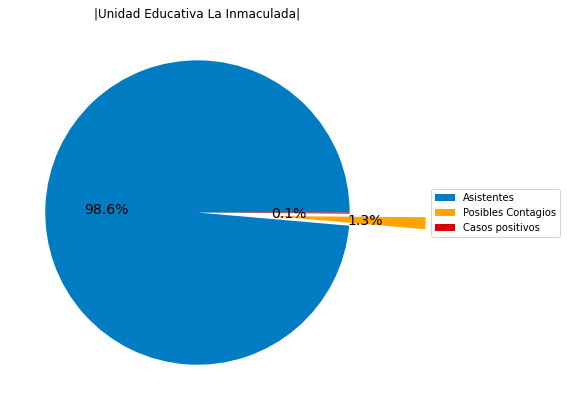

In [25]:
import matplotlib.pyplot as plt 

x = round(asistentes) # Asistentes durante el periodo de prueba
y = cont # Posibles estudiantes contagiados
z = len(registro.listaPositivos) # Casos positivos COVID-19

plt.figure(figsize=(12,7))
etiquetas = ['Asistentes','Posibles Contagios','Casos positivos']
colors = ['#007CC2','#FFA500','#D70006']
explode = (0, 0.5,0)
plt.pie([x,y,z], autopct='%1.1f%%', startangle=0, colors=colors,textprops={'color':"black", "size":"14"}, explode=explode)
plt.title('|Unidad Educativa La Inmaculada|')
plt.legend(etiquetas, title="", loc="center left", bbox_to_anchor=(1.1, 0, 0.5, 1))
plt.show()

### Determinar cuantos cursos se deben cerrar según el porcentaje de casos positivos presentes en un curso:

- Menos del 20% de estudiantes son casos positivos se cierra un curso.
- Entre el 20% - 40% de estudiantes son casos positivos se cierran dos cursos.
- Entre el 40% - 50% de estudiantes son casos positivos se cierran tres cursos.
- Mas del 50% se cierra la unidad educativa.

In [26]:
def porcentajeContagiados(estudiantesCurso, casosPositivos):
    resultado = (100*casosPositivos)/estudiantesCurso
    return resultado

resultado = porcentajeContagiados(round(asistentes/escuela.cursos.capacity), len(registro.listaPositivos))
cursosCerrar = 0

if(resultado > 0 and resultado <= 20):
    cursosCerrar = 1
elif(resultado > 20 and resultado <= 40):
    cursosCerrar = 2
elif(resultado > 40 and resultado <= 50):
    cursosCerrar = 3
else:
    cursosCerrar = CURSOS

estudiantesRetirar = round(escuela.estudiantes.level/(escuela.cursos.capacity-cursosCerrar))*cursosCerrar

In [29]:
print(f'Debido a los {len(registro.listaPositivos)} casos positivos, se ha determinado que se cierren {cursosCerrar} curso/s')
print(f'Y se retiran a {estudiantesRetirar} estudiantes.')
print(f'Debido al cierre de los cursos {cursosCerrar} docente/s no podrán laborar.')

Debido a los 1 casos positivos, se ha determinado que se cierren 1 curso/s
Y se retiran a 18 estudiantes.
Debido al cierre de los cursos 1 docente/s no podrán laborar.


## Inicia la simulación despues de las pruebas PCR
- Se procede a cerrar el número de cursos antes obtenido y a retirar un determinado número de estudiantes y docentes.

In [30]:
env = simpy.Environment()

# Se determina una nueva cantidad de asistentes a la escuela en base a los cursos cerrados.
asistentes -= estudiantesRetirar
docentes -= cursosCerrar
escuela = Escuela(env, CURSOS-cursosCerrar, round(asistentes), docentes)

# Se cierra uno de los cursos y los estudiantes retornan a clases por otros 30 días.
env.process(estudiantes(registro, escuela, round(asistentes), docentes, escuela.cursos.capacity))
env.run(until=TIEMPO_SIMULACIÓN)

pruebasPCR = pruebaPCR(registro, escuela, round(asistentes))


                 ***  NUEVO DÍA  ***             

El día 2021-07-14 inicia con 841 estudiantes y 54 docentes a las: 07:00:00.
Todos los estudiantes han ingresado a sus cursos a las 07:03:00.
Curso 1 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 2 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 3 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 4 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 5 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 6 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 7 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 8 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 9 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 10 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 11 esta disponible y esta sien

Curso 44 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 45 esta disponible y esta siendo utilizado con 17 estudiantes presentes
Curso 46 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 47 esta disponible y esta siendo utilizado con 17 estudiantes presentes
Los estudiantes terminan clases a las 13:00:00 y vuelven a sus hogares.

                 ***  NUEVO DÍA  ***             

El día 2021-07-31 inicia con 841 estudiantes y 54 docentes a las: 07:00:00.
Todos los estudiantes han ingresado a sus cursos a las 07:04:00.
Curso 1 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 2 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 3 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 4 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 5 esta disponible y esta siendo utilizado con 18 estudiantes presentes
Curso 6 esta disponible y esta siendo 

## Finaliza simulación después del periodo de prueba.
#### Métricas obtenidas
- Estudiantes y docentes que asistieron después el periodo de prueba.
- Estudiantes que pudieron resultar contagiados durante el receso en esta nueva simulación.
- Estudiantes con resultado positivo a las pruebas PCR en la nueva simulación.

In [31]:
# Métricas luego de cerrar n cursos y retirar a determinados estudiantes.
print('DESPUÉS DEL PERIODO DE PRUEBA')
print(f'Asistentes: Después del periodo de prueba y de haber realizado las pruebas PCR asistieron {round(asistentes)} estudiantes y {docentes} docentes a la unidad educativa.\n')

for key, value in registro.listaAsistentes.items():
    if value == 'Contagiado-Receso':
        print(f'El estudiante {key} pudo resultar contagiado durante el receso **posible nuevo**')
        cont+=1

print(f'Después de otros 30 días de clases existirían {cont} posibles casos de contagio durante los recesos en total. \n')

print(f'Finalmente las pruebas PCR arrojan que {len(registro.listaPositivos)} estudiante/es resultaron ser casos positivos de COVID-19 \ndurante la simulación')

for k in registro.listaPositivos:
    print(f'El estudiante {k} es positivo para COVID-19')

DESPUÉS DEL PERIODO DE PRUEBA
Asistentes: Después del periodo de prueba y de haber realizado las pruebas PCR asistieron 841 estudiantes y 54 docentes a la unidad educativa.

El estudiante 45 pudo resultar contagiado durante el receso **posible nuevo**
El estudiante 247 pudo resultar contagiado durante el receso **posible nuevo**
El estudiante 293 pudo resultar contagiado durante el receso **posible nuevo**
El estudiante 395 pudo resultar contagiado durante el receso **posible nuevo**
El estudiante 434 pudo resultar contagiado durante el receso **posible nuevo**
El estudiante 440 pudo resultar contagiado durante el receso **posible nuevo**
El estudiante 514 pudo resultar contagiado durante el receso **posible nuevo**
El estudiante 530 pudo resultar contagiado durante el receso **posible nuevo**
El estudiante 613 pudo resultar contagiado durante el receso **posible nuevo**
El estudiante 687 pudo resultar contagiado durante el receso **posible nuevo**
El estudiante 708 pudo resultar conta

### Gráfica al finalizar la simulación de 2 meses (Periodo de prueba y luego de cerrar n cursos)

Después de finalizada la simulación de 2 meses se evidencia en una gráfica la totalidad de asistentes y el total de posibles contagios y la totalidad de casos positivos en la institución.

- Asistentes a la unidad educativa durante la simulación.
- Posibles contagios contemplados durante la simulación.
- Casos totales con resultado positivo luego de realizar las pruebas PCR.

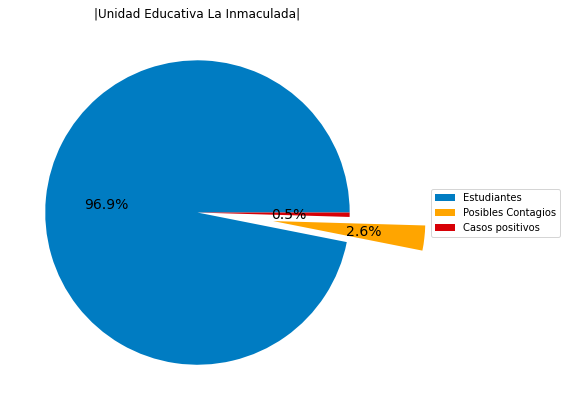

In [40]:
#Graficas de los casos posibles y los casos positivos PCR
import matplotlib.pyplot as plt 

x = round(asistentes) # Asistentes durante el periodo de prueba
y = cont # Posibles estudiantes contagiados
z = len(registro.listaPositivos) # Casos positivos COVID-19

plt.figure(figsize=(12,7))
etiquetas = ['Estudiantes','Posibles Contagios','Casos positivos']
colors = ['#007CC2','#FFA500','#D70006']
explode = (0, 0.5,0)
plt.pie([x,y,z], autopct='%1.1f%%', startangle=0, colors=colors,textprops={'color':"black", "size":"14"}, explode=explode)
plt.title('|Unidad Educativa La Inmaculada|')
plt.legend(etiquetas, title="", loc="center left", bbox_to_anchor=(1.1, 0, 0.5, 1))
plt.show()

### Gráfica de los estudiantes que asisten a la unidad educativa durante la simulación.

En esta gráfica se envidencia como ha ido la asistencia de los estudiantes en las diferentes etapas de la simulación. 

- Estudiantes matriculados.
- Estudiantes que pueden asistir durante el primer mes debido a que están vacunados y no presentan enfermedades.
- Estudiantes que pueden asistir luego de haber dado negativo en las pruebas PCR realizadas.

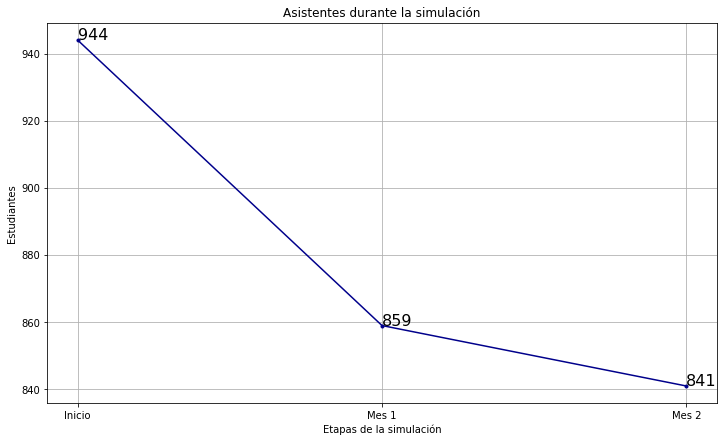

In [41]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize = (12,7))
ax = fig.add_subplot(111)

plt.title("Asistentes durante la simulación")
plt.xlabel("Etapas de la simulación")
plt.ylabel("Estudiantes")

asistentes1Mes = round(asistentes + estudiantesRetirar)

A = ['Inicio','Mes 1', 'Mes 2']
B = [ESTUDIANTES, asistentes1Mes, round(asistentes)]

plt.plot(A,B,'.-', label='Tiempo Espera', color='darkblue')

for xy in zip(A, B):
    ax.annotate('%s' % xy[1], xy=xy, textcoords='data', fontsize=16)

plt.grid()
plt.show()

### Gráfica de los docentes que asisten a la unidad educativa durante la simulación.
- Docentes contratados para el reingreso a clases.
- Docentes habilitados para asistir durante el primer mes debido a que están vacunados.
- Docentes que pueden asistir debido a que su curso no fue cerrado.

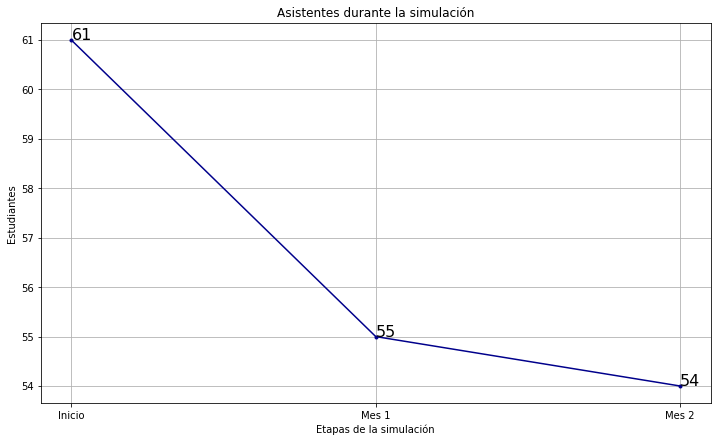

In [42]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize = (12,7))
ax = fig.add_subplot(111)

plt.title("Asistentes durante la simulación")
plt.xlabel("Etapas de la simulación")
plt.ylabel("Estudiantes")

asistentes1Mes = round(asistentes + estudiantesRetirar)
docentes1Mes = round(docentes + cursosCerrar)

A = ['Inicio','Mes 1', 'Mes 2']
B = [DOCENTES, docentes1Mes, docentes]

plt.plot(A,B,'.-', label='Tiempo Espera', color='darkblue')

for xy in zip(A, B):
    ax.annotate('%s' % xy[1], xy=xy, textcoords='data', fontsize=16)

plt.grid()
plt.show()

### Gráfica de la disponibildiad de los cursos en la unidad educativa durante la simulación.
- Cursos abiertos al inicio de las clases.
- Cursos habilitados durante el primer mes.
- Cursos disponibles luego de haber realizado las pruebas PCR.

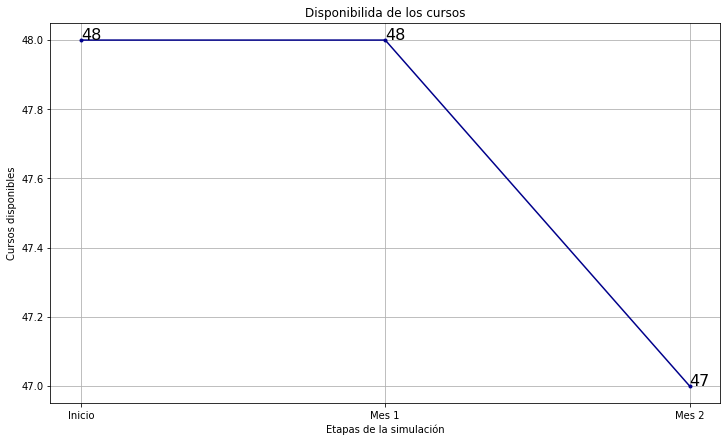

In [43]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize = (12,7))
ax = fig.add_subplot(111)

plt.title("Disponibilida de los cursos")
plt.xlabel("Etapas de la simulación")
plt.ylabel("Cursos disponibles")

A = ['Inicio','Mes 1', 'Mes 2']
B = [CURSOS, round(escuela.cursos.level+cursosCerrar), round(escuela.cursos.level)]

plt.plot(A,B,'.-', label='Tiempo Espera', color='darkblue')

for xy in zip(A, B):
    ax.annotate('%s' % xy[1], xy=xy, textcoords='data', fontsize=16)

plt.grid()
plt.show()

### Opinión

- El modelo desarrollado muestra que existe un porcentaje mayor de posibles contagiados durante los recesos y debido al porcentaje de contagio, en contraste con el total de casos positivos luego de realizar las pruebas PCR .
- El porcentaje de pruebas PCR a realizar debería aumentar para estar en relación con la cantidad de posibles contagiados durante la simulación

### Conclusiones

- Los datos de la unidad eductativa deben ser obtenidos de fuentes reales para tener una simulación similar al sistema real.
- Este tipo de simulaciones según las condiciones planteadas permiten conocer: cual es el comportamiento de los estudiantes durante el reingreso a clases y las acciones que se deberían realizar al existir n casos positivos luego de las pruebas PCR.

### Recomendaciones

- El tiempo de la simulación debe ser similar a la duración de una jornada de estudio en una unidad educativa.
- Se deben determinar y asegurar que se cumplan los porcentajes para cumplir con las condiciones de cada uno de los escenarios de simulación.